# Семинар
## Трансформеры

## BPE


**Проблема**

 - Токенизация слов слишком высокоуровнева
 - Токенизация по буквам слишком низкоуровнева


 **Решение**

 Будем соединять токены, пока не достигнем определенного числа.

![](https://lena-voita.github.io/resources/lectures/seq2seq/bpe/build_merge_table.gif)

In [1]:
!pip install -q youtokentome
!pip install -q datasets

     |████████████████████████████████| 1.7MB 8.5MB/s 
     |████████████████████████████████| 153kB 8.5MB/s 
     |████████████████████████████████| 245kB 17.8MB/s 
     |████████████████████████████████| 17.7MB 243kB/s 


In [2]:
from datasets import load_dataset
from youtokentome import BPE

In [3]:
dataset = load_dataset("ag_news")

Using custom data configuration default


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


In [4]:
with open("data.txt", "w") as out:
    for data_d in dataset["train"]:
        out.write(data_d["text"]+"\n")

In [5]:
bpe = BPE.train(data="data.txt", vocab_size=5000, model="bpe.bin")

In [6]:
encoded = bpe.encode("Hello there! What is BPE?")

In [7]:
tokenized = ""
for word in encoded:
    tokenized += " " + bpe.id_to_subword(word)
tokenized

' ▁H ell o ▁there ! ▁What ▁is ▁B P E ?'

## GPT 2


### Encoder vs Decoder

Так в чем разница?


![](http://jalammar.github.io/images/gpt2/self-attention-and-masked-self-attention.png)

## Авторегрессионный трансформер

![](http://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif)

In [8]:
import torch
from torch import nn

### Attention implementation


<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-2.png" width="800">

In [9]:
def get_qkv(self, inp):
    qkv = self.c_attn(inp)
    return qkv

<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-3.png" width="800">

In [10]:
def split_qkv(self, inp):
    return imp.split(self.split_size, dim=2)

<img src="http://jalammar.github.io/images/gpt2/gpt2-self-attention-split-attention-heads-1.png" width="800">

In [ ]:
def split_heads(self, q, k, v):

    batch_s = q.size(0)
    seq_length = q.size(1)
    n_heads = self.n_heads
    head_features_size =  q.size(-1) // self.n_head

    new_x_shape = (batch_s, seq_length, n_heads, head_features_size)

    q = q.view(*new_x_shape)
    k = k.view(*new_x_shape)
    v = v.view(*new_x_shape)

    q = q.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)
    k = k.permute(0, 2, 3, 1)  # k = k^T
    v = v.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    return q, k , v

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-scoring-2.png width=800>

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-multihead-sum-1.png width=800>

$$ \text{Softmax}(\frac{Q\cdot K^T}{\sqrt{d}}) \cdot V$$

In [ ]:
def attn(self, q, k, v):
    w = torch.matmul(q, k)  # q k^t
    d = float(v.size(-1))
    w /= d**0.5
    scores = nn.Softmax(dim=-1)(w)
    result = torch.matmul(scores, v)  # weighted sum 
    return result, scores
    

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-merge-heads-1.png width=800>



In [ ]:
def merge_heads(self, w):
    batch_size = w.size(0)
    w = w.permute(0, 2, 1, 3)  # (batch_size, seq_length, head_num, head_features)
    w = w.contiguous()  # reallocate tensor
    seq_length = w.size(1)
    w = w.view(batch_size, seq_length, w.size(-2)*w.size(-1))
    return w

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-project-2.png width=800>



In [ ]:
def project(self, w):
    return self.c_proj(w)  # nn.Linear(w = w_1 v_1 + w_2 v_2...)

<img src=http://jalammar.github.io/images/gpt2/gpt2-self-attention-qkv-3-2.png width=800>


In [ ]:
class Attention(nn.Module):
    def __init__(self, emb_dim:int = 768, n_head: int = 12):
        super().__init__()

        n_state = emb_dim
        self.n_head = n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = nn.Linear(emb_dim, 3 * emb_dim)
        self.c_proj = nn.Linear(emb_dim, emb_dim)

    def forward(
        self,
        hidden_states,
        layer_past=None,
        use_cache=False,
        output_attentions=False,
    ):
        qkv = get_qkv(self, hidden_states)
        query, key, value = split_qkv(self, qkv)
        query, key, value = split_heads(self, query, key, value)

        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)

        attn_outputs = attn(self, query, key, value)
        a = attn_outputs[0]
        scores = attn_outputs[1]

        a = merge_heads(self, a)
        a = project(self, a)
        outputs = [a]
        if use_cache:
            present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        else:
            present = (None,)
        outputs.append(present)
        if output_attentions:
            outputs.append(scores)
        

        return outputs

### Feed Forward

<img src=http://jalammar.github.io/images/gpt2/gpt2-mlp1.gif width=800>

<img src=http://jalammar.github.io/images/gpt2/gpt2-mlp-2.gif width=800>


In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, emb_dim: int = 768):
        self.c_fc = nn.Linear(emb_dim, emb_dim * 4)
        self.activ = nn.ReLU()
        self.c_proj = nn.Linear(emb_dim * 4, emb_dim)

    def forward(self, inp):
        inp = self.c_fc(inp)
        inp = self.activ(inp)
        return self.c_proj(inp)

<img src=http://jalammar.github.io/images/gpt2/gpt2-transformer-block-weights-2.png width=800>



### Decoder Block

In [ ]:
class Block(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        hidden_size = emb_dim
        self.ln_1 = nn.LayerNorm(hidden_size, eps=1e-5)
        self.attn = Attention(hidden_size, n_head=12)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=1e-5)
        self.ff = FeedForwardNetwork(inner_dim)

    def forward(
        self,
        hidden_states,
        layer_past=None,
        use_cache=False,
        output_attentions=False,
    ):
        attn_outputs = self.attn(
            self.ln_1(hidden_states),
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + hidden_states

        feed_forward_hidden_states = self.ff(self.ln_2(hidden_states))
        # residual connection
        hidden_states = hidden_states + feed_forward_hidden_states

        outputs = [hidden_states] + outputs
        return outputs  # hidden_states, present, (attentions)

## Huggingface's transformers

![](https://raw.githubusercontent.com/huggingface/transformers/master/docs/source/imgs/transformers_logo_name.png)

In [11]:
!pip install -q transformers

     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 890kB 34.3MB/s 
     |████████████████████████████████| 2.9MB 48.9MB/s 
     |████████████████████████████████| 1.1MB 47.2MB/s 


In [13]:
import torch

from transformers import GPT2LMHeadModel
from transformers import GPT2Tokenizer

In [14]:
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
ru_gpt = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", output_attentions=True)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ru_gpt.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [16]:
start = tokenizer.encode(
    "В банке можно заказать кофе", 
    return_tensors="pt"
)

result = ru_gpt.generate(
    start.to(device), 
    max_length=20,
    num_beams=10,
    early_stopping=True, 
    no_repeat_ngram_size=3,
)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [17]:
print(tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True))

В банке можно заказать кофе-брейк с доставкой на дом или в офис.





## Внутри Attention

In [18]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1074, done.
remote: Total 1074 (delta 0), reused 0 (delta 0), pack-reused 1074
Receiving objects: 100% (1074/1074), 99.41 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (687/687), done.


In [19]:
from bertviz import model_view
from transformers import GPT2Tokenizer, GPT2Model

In [20]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [21]:
text = tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True)
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = ru_gpt(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import numpy as np

def get_attention_matrixes(model, tokenizer, text, device="cpu"):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [23]:
generated = tokenizer.decode(
    result.cpu().flatten().numpy(), 
    skip_special_tokens=True
)

attn = get_attention_matrixes(ru_gpt, tokenizer, generated)

In [24]:
seq = [tokenizer.decode([result.numpy().flatten()[i]]) for i in range(20)]

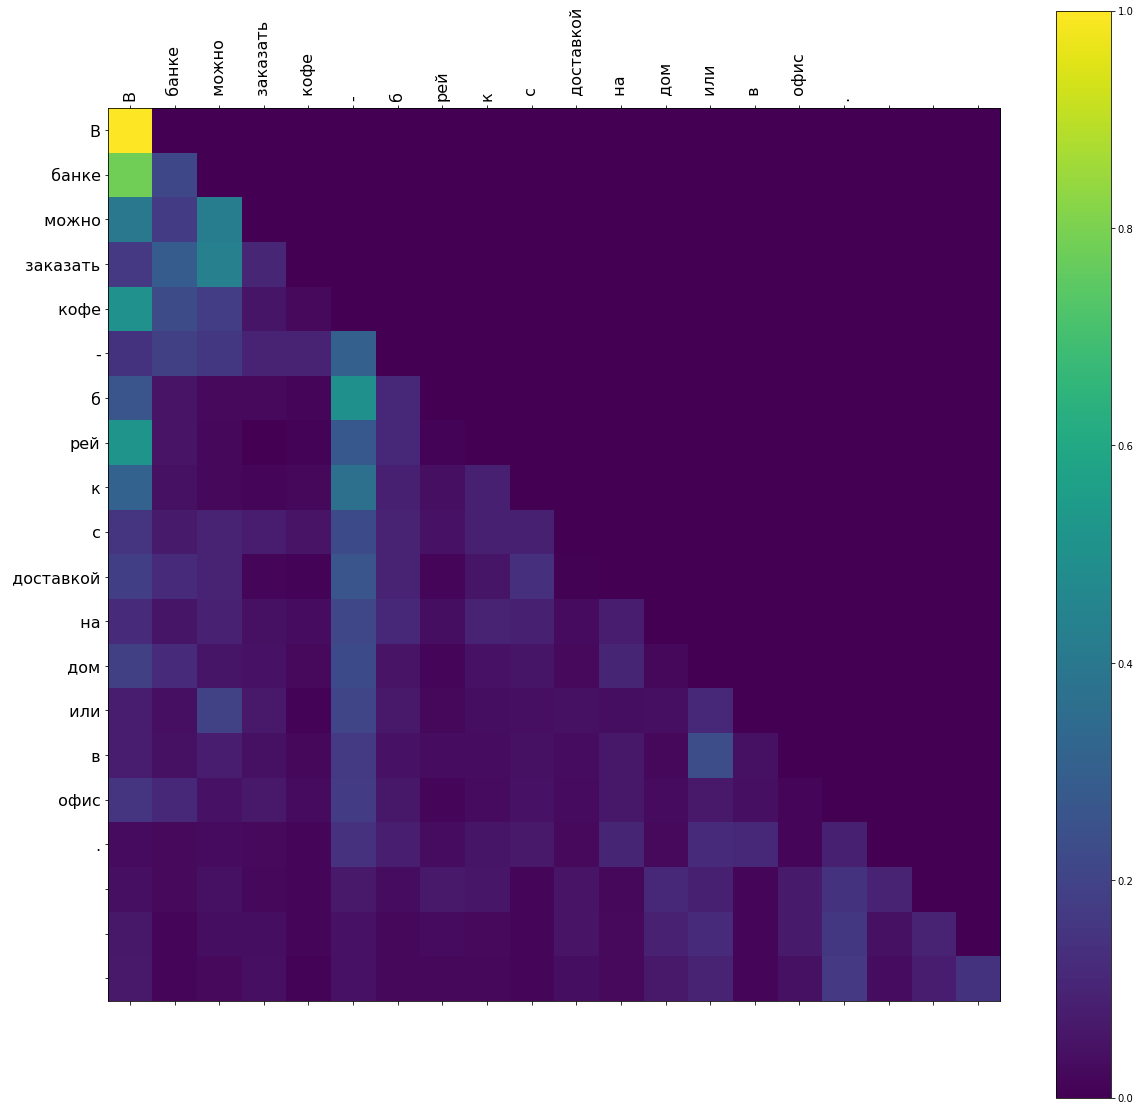

In [25]:
from matplotlib import pyplot as plt
from matplotlib import ticker

def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

show_attention(seq, attn[1][-2])

In [29]:
inp = """
один плюс один равно два
Два плюс три равно пять
три плюс четыре 
"""

encoded = tokenizer.encode(inp, return_tensors="pt")


result = ru_gpt.generate(encoded, max_length=30)

print(tokenizer.decode(result.cpu().flatten().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence



один плюс один равно два
Два плюс три равно пять
три плюс четыре 
















# Полезные ссылки

1. https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html
2. http://jalammar.github.io/illustrated-transformer/
3. http://jalammar.github.io/illustrated-gpt2/
